In [2]:
import struct
import numpy as np
import os
from joblib import Parallel, delayed

In [3]:
import matplotlib.pyplot as plt
import healpy as hp
nside = 128
npix = hp.nside2npix(nside)

%matplotlib inline

In [4]:
def getRadialUnitVecs(spherePos):
    unitVecs = np.zeros((len(spherePos),3))
    
    #negative because you want it pointing towards the origin    
    unitVecs[:,0] = -np.multiply(np.cos(spherePos[:,2]),np.sin(spherePos[:,1]))
    unitVecs[:,1] = -np.multiply(np.sin(spherePos[:,2]),np.sin(spherePos[:,1]))
    unitVecs[:,2] = -np.cos(spherePos[:,1])
    
    return unitVecs

In [5]:
def getScalingFactorSquared(radius):
    a= -0.01*radius+1
    return np.power(a,2)

In [6]:
def getScalingFactor(radius):
    return -0.01*radius+1

In [7]:
def convertToSpherical(xyz):
    #variables
    sphericalConversion = np.zeros((len(xyz),4))
    vel = np.zeros((len(xyz),3))
    
    # col 0: r, col 1: theta, col 2: phi
    
    xySquared = xyz[:,0]**2 + xyz[:,1]**2
    # r
    sphericalConversion[:,0] = np.sqrt(xySquared+xyz[:,2]**2)
    # theta - many options for this calc
    
    sphericalConversion[:,1] = np.arctan2(np.sqrt(xySquared), xyz[:,2])
    
    # phi
    sphericalConversion[:,2] = np.arctan2(xyz[:,1],xyz[:,0])
    
    #convert velocity to radial velocity over radius^2
    
    vel[:,0] = xyz[:,3]/(np.multiply(getScalingFactor(sphericalConversion[:,0]),np.power(sphericalConversion[:,0],2)))
    vel[:,1] = xyz[:,4]/(np.multiply(getScalingFactor(sphericalConversion[:,0]),np.power(sphericalConversion[:,0],2)))
    vel[:,2] = xyz[:,5]/(np.multiply(getScalingFactor(sphericalConversion[:,0]),np.power(sphericalConversion[:,0],2)))
    
    unitVectors = getRadialUnitVecs(sphericalConversion)
    
    #get the radial 
    for i in range(len(xyz)):
        sphericalConversion[i,3] = np.dot(vel[i],unitVectors[i])
    
    return sphericalConversion

In [8]:
# Reading lp-cola unformatted files
def unf_read_file(file, p_list=[], np=6):
    with open(file, mode='rb') as f:
        tot_n = 0
        cnt = 0
        while (True):
            cnt += 1
            r = f.read(4)
            if not r: break
            a1 = struct.unpack('i', r)
            r = f.read(a1[0])
            n = struct.unpack('i', r)
            r = f.read(8)
            a, b = struct.unpack('2i', r)
            r = f.read(b)
            p_list.extend(struct.unpack(str(n[0] * np) + 'f', r))
            r = f.read(4)
            tot_n += n[0]
    f.close()
    return tot_n

In [11]:
def readSetToBins(startFile, stopFile, index):
    tempArray = []
    numcount = []
    totalVelThread = np.zeros(npix)
    for i in range(startFile,stopFile):
        path = "Data/cone_test_lightcone."+str(i)
        if os.path.isfile(path):
            unf_read_file(path, p_list=tempArray)

            reshaped = np.reshape(tempArray,(-1,6))
            tempArray = []
                                 
            offset = np.append(64*np.ones((np.shape(reshaped)[0],3)),np.zeros((np.shape(reshaped)[0],3)),axis=1)
            
            reshaped = np.subtract(reshaped,offset)
            
            sphereConversion = convertToSpherical(reshaped)
            
            reshaped = []
            
            #only take points within a certain radius
            sphereConversion = sphereConversion[sphereConversion[:,0]<30]

            #determine how many points are in each bin
            pixIndicies = hp.ang2pix(nside,sphereConversion[:,1],sphereConversion[:,2])

            if len(numcount)==0:
                numcount = np.bincount(pixIndicies, minlength=npix)
            else:
                numcount = np.add(numcount, np.bincount(pixIndicies, minlength=npix) )
                
            #do the math for the SZ effect
            
            #sum all velocities in each bin together
            if(len(pixIndicies)>0):
                for j in range(np.amin(pixIndicies),np.amax(pixIndicies)+1):
                    velInBin = sphereConversion[pixIndicies==j][:,3]
                    totalVelThread[j] = np.sum(velInBin,axis=0)
            
            if i%10==0:
                print(i)
                
        return [numcount, totalVelThread]

In [12]:
numProcess = 32
ranges = np.linspace(0,32,numProcess+1).astype(int)

returnValues = Parallel(n_jobs=numProcess)(delayed(readSetToBins)(ranges[i],ranges[i+1], i) for i in range(0,numProcess))

In [46]:
np.array(returnValues)[0:-1,0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [75]:
outputCount = np.array(returnValues)[0:-1,0]
outputkSZ = np.array(returnValues)[0:-1,1]

In [76]:
np.sum(outputCount)

676323.0

In [77]:
np.sum(outputkSZ)

-70548.59678858965

676323.0


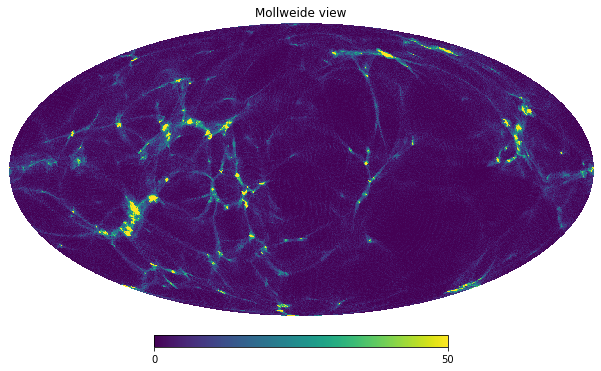

In [78]:
numcount = np.sum(outputCount,axis=0)
print(sum(numcount))

n_bar = np.average(numcount)
overdensity = (numcount-n_bar)/n_bar

hp.mollview(numcount,xsize=3200, max=50)

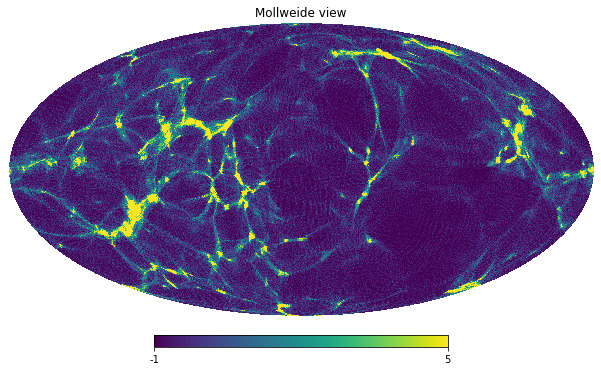

In [79]:
hp.mollview(overdensity,xsize=3200,max=5)

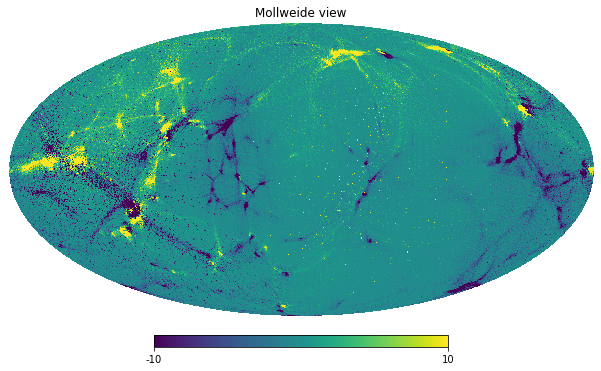

In [80]:
almostkSZ = np.sum(outputkSZ,axis=0)
hp.mollview(almostkSZ,xsize=3200,min=-10,max=10)

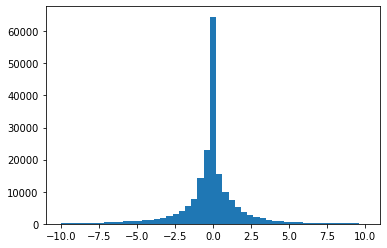

In [81]:
plt.hist(almostkSZ,bins=np.linspace(-10,10));

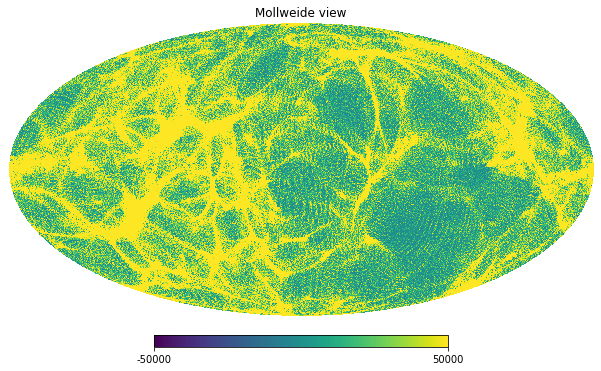

In [72]:
almosterkSZ = almostkSZ/(hp.nside2resol(nside)**2)
hp.mollview(almosterkSZ,xsize=3200,min=-50000,max=50000)

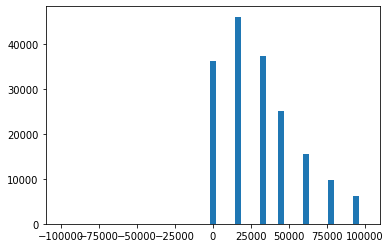

In [73]:
plt.hist(almosterkSZ,bins=np.linspace(-100000,100000));